# Generate Pipeline Images

This notebook generates images from the pipelien: Detection, Keypoint Estimatio, Pose Parsing

In [1]:
import os
import sys
from tqdm import tqdm

import numpy as np
import cv2
import torch
from torch.nn import DataParallel
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import matplotlib.pyplot as plt

sys.path.append("..")

import models
from data.data_loaders import get_detection_dataset 
import data.data_processing as data_processing
from lib.transforms import TransformDetection
import lib.utils as utils
import lib.model_setup as model_setup
import lib.visualizations as visualizations
import lib.pose_parsing as pose_parsing
import lib.bounding_box as bbox_lib
from CONFIG import CONFIG
import CONSTANTS

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
detector_exp = os.path.join("detector_tests", "arch_styled_faster_rcnn")
detector_path = os.path.join(CONFIG["paths"]["experiments_path"], detector_exp)
detector_name = "checkpoint_epoch_final.pth"
detector_checkpoint = os.path.join(detector_path, "models", "detector", detector_name)

hrnet_exp = os.path.join("hrnet_tests", "arch_styled_hrnet_exp_1")
hrnet_path = os.path.join(CONFIG["paths"]["experiments_path"], hrnet_exp)
hrnet_name = "checkpoint_epoch_10.pth"
hrnet_checkpoint = os.path.join(hrnet_path, "models", hrnet_name)

data_path = CONFIG["paths"]["data_path"]
exp_data = utils.load_experiment_parameters(detector_path)
save_dir = os.path.join(os.getcwd(), "imgs", "pipeline_imgs")

In [7]:
pose_parsing.SKELETON = CONSTANTS.SKELETON_HRNET
data_processing.TO_COCO_MAP = CONSTANTS.COCO_MAP_HRNET
data_processing.SKIP_NECK = False

# 0. Model Setup

In [8]:
detector = model_setup.setup_detector()
detector = DataParallel(detector)
detector = model_setup.load_checkpoint(checkpoint_path=detector_checkpoint,
                                       model=detector, only_model=True)
detector = detector.eval()

In [9]:
hrnet = model_setup.load_model(exp_data)
hrnet = DataParallel(hrnet)
hrnet = model_setup.load_checkpoint(checkpoint_path=hrnet_checkpoint,
                                    model=hrnet, only_model=True, map_cpu=True)
hrnet = hrnet.eval()

Loading COCO pretrained weights...


# 1. Dataset

In [10]:
exp_data["dataset"]["dataset_name"] = "open_subset"
_, data_loader, _, dataset = get_detection_dataset(exp_data, train=False, get_dataset=True)
print(f"'Open_Subset' dataset contains {len(dataset)} images")

'Open_Subset' dataset contains 71 images


In [76]:
# sampling image
idx = 18
# idx = np.random.randint(low=0, high=len(dataset))
img, meta = dataset[idx]
img_name = meta['image_name']
prefix = img_name.split(".")[0]
print(f"Processing image '{img_name}'")

Processing image 'v0441.jpe'


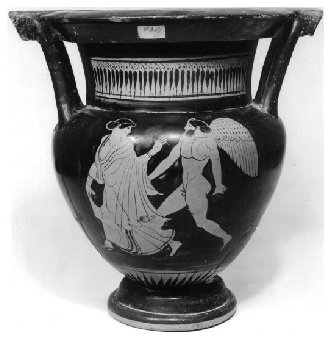

In [77]:
# displaying and saving original
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.imshow(img.transpose(1,2,0))
plt.axis("off")
plt.savefig(os.path.join(save_dir, f"{prefix}_original.png"))
plt.show()

# 2. Detection

In [78]:
img_forward = torch.Tensor(img[np.newaxis, :])
output = detector(img_forward / 255)

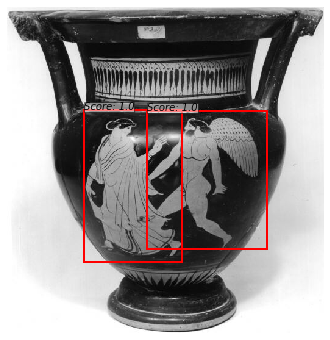

In [79]:
boxes, labels, scores = bbox_lib.bbox_filtering(output, filter_=1, thr=0.7)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)
visualizations.visualize_bbox(img.transpose(1,2,0) / 255, boxes=boxes[0], 
                              scores=scores[0], labels=labels[0], 
                              savepath=os.path.join(save_dir, f"{prefix}_dets.png"),
                              axis_off=True, ax=ax)

# 3. Cropping and Scaling

In [80]:
get_detections = TransformDetection(det_width=192, det_height=256)

In [81]:
img_extract = img.transpose(1,2,0)
detections, centers, scales = get_detections(img=img_extract, list_coords=boxes[0])

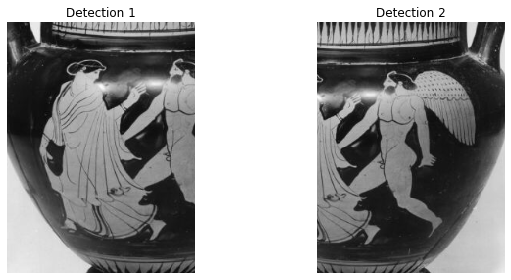

In [82]:
n_dets = detections.shape[0]
fig, ax = plt.subplots(1, n_dets)
if(n_dets == 1):
    ax = [ax]
fig.set_size_inches(5*n_dets, 4)
for i,det in enumerate(detections):
    title = f"Detection {i+1}"
    visualizations.visualize_image(det, ax=ax[i], preprocess=True, title=title)
    ax[i].axis("off")
plt.tight_layout()

# 4. Keypoint Detection

In [83]:
normalize = transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            )
normed_detections = [normalize(torch.Tensor(det/255)).numpy() for det in detections]

In [84]:
# forward pass through HTNer for keypoint detection
keypoint_dets = hrnet(torch.Tensor(normed_detections).float())
scaled_dets = F.interpolate(keypoint_dets.clone().detach(), (256, 192),
                            mode="bilinear", align_corners=True)

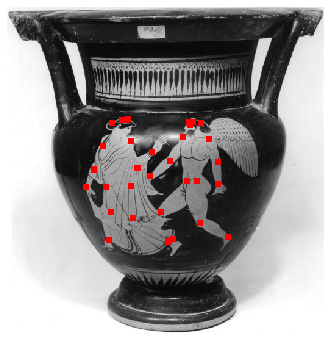

In [85]:
keypoints, max_vals, coords = pose_parsing.get_final_preds_hrnet(keypoint_dets.cpu().detach().numpy(), centers, scales)
thr = 0.2
zoom = 5

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8, 6)
for idx in range(keypoints.shape[0]): 
    for i, k in enumerate(keypoints[idx,:]):
        if(max_vals[idx,i,:] < thr):
            continue
        k = [int(k_) for k_ in k]
        img[0, k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom] = 255
        img[1, k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom] = 0
        img[2, k[1]-zoom:k[1]+zoom, k[0]-zoom:k[0]+zoom] = 0
visualizations.visualize_image(img.transpose(1,2,0), ax=ax)
ax.axis("off")

plt.savefig(os.path.join(save_dir, f"{prefix}_kpts.png"))
plt.show()

# 5. Pose Parsing

In [86]:
keypoint_coords, max_vals = pose_parsing.get_max_preds_hrnet(scaled_dets.cpu().detach().numpy())
indep_pose_entries, indep_all_keypoints = pose_parsing.create_pose_entries(keypoint_coords,  max_vals, thr=0.2)

indep_all_keypoints = [indep_all_keypoints[:, 1], indep_all_keypoints[:, 0], indep_all_keypoints[:, 2], indep_all_keypoints[:, 3]]
indep_all_keypoints = np.array(indep_all_keypoints).T

In [87]:
# detecting keypoint detection and pose parsing
keypoints, max_vals, coords = pose_parsing.get_final_preds_hrnet(keypoint_dets.cpu().detach().numpy(), centers, scales)
pose_entries, all_keypoints = pose_parsing.create_pose_entries(keypoints, max_vals, thr=0.2)

all_keypoints = [all_keypoints[:, 1], all_keypoints[:, 0], all_keypoints[:, 2], all_keypoints[:, 3]]
all_keypoints = np.array(all_keypoints).T

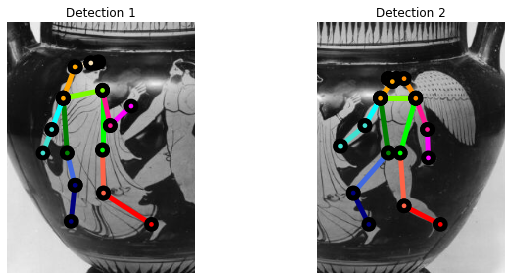

In [88]:
n_dets = detections.shape[0]
fig, ax = plt.subplots(1, n_dets)
if(n_dets == 1):
    ax = [ax]
fig.set_size_inches(5*n_dets, 4)
for i,det in enumerate(detections):
    title = f"Detection {i+1}"
    visualizations.draw_pose(det, [indep_pose_entries[i]], indep_all_keypoints,
                             ax=ax[i], title=title, preprocess=True, axis_off=True)
plt.tight_layout()

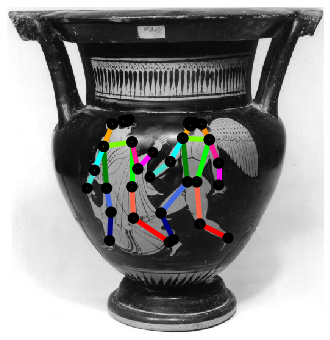

In [89]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)

title = f"Detected Poses"
visualizations.draw_pose(img.transpose(1,2,0) / 255,
                         pose_entries, all_keypoints, ax=ax, axis_off=True,
                         savepath=os.path.join(save_dir, f"{prefix}_poses.png"))
plt.show()

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
   This notebook was created by <b>Angel Villar-Corrales</b>
</div> 